# Predictions With Simulated Times Series Data

## Part 1 - Align The Time Series
The first part of the problem was to process the given csv file so that all the different times series would be aligned and the data could be used for modeling. I read the data with Python and changed the format and transposed it to make it look like the sample file, and then loaded it into a Pandas dataframe.


In [36]:
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 12 08:30:19 2019
@author: andri
"""

import csv
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA
from sklearn.metrics import r2_score
from operator import add
 
rows_list = []
features_list =   []
features_list2=   []

path = 'C:/Users/andri/Desktop/Icelandair/'

counter = 0
with open(path+'sdata.csv', 'rb') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=';') # Making use of reader method for reading the file
    for line in csv_reader: #Iterate through the loop to read line by line
        if counter<=362:
            rows_list.append(line)
        if counter>=756:
            features_list.append(line)
        counter+=1

for i in range(0, 359): 
    features_list2.append(features_list[i][1])

# Transpose data to make it same format as sample file
cols = np.array(rows_list).T.tolist()

pd.set_option('display.max_columns', 15)
pd.set_option('display.max_rows', 50)

df = pd.DataFrame(cols)
df = df[:][0:122] #only get data with dates
df=df.rename(columns={0: "Dates"})

df.to_csv ('output_dept_dates_aligned.csv', index = None, header=True)


# The dataframe is ready with all time series aligned (see below)
df


,Dates,1,2,3,4,5,6,...,356,357,358,359,360,361,362
0,01/10/17 00:00,,,,"222,02","340,44","480,32",...,"31091,16","45676,84","44680,74","35453,54","74761,01","53803,71","39496,7"
1,02/10/17 00:00,,,,,,"124,27",...,"45866,95","33708,62","35317,97","59414,86","31497,85","61297,56",33818
2,03/10/17 00:00,,,,,"79,48","893,8",...,"31521,22","24448,74","37863,04","12145,93","18007,03","57726,61","24914,08"
3,04/10/17 00:00,,,,,,,...,"45478,36","30441,48","9330,35","13051,11","42523,96","36410,89","36257,89"
4,05/10/17 00:00,,,,"254,06","686,5",,...,"43517,62","11628,92","6442,99","37959,58","37875,09","52255,59","42725,13"
5,06/10/17 00:00,,,,"1854,5",,"164,74",...,"14116,27","9007,03","29146,29","25947,22","25288,78","37617,88","37765,24"
6,07/10/17 00:00,,,,"1268,92","859,32","730,36",...,"12793,38","22218,84","16086,42","35334,69","27079,41","36727,29","27025,72"
7,08/10/17 00:00,"577,39",,"556,18","2846,17","354,8","705,36",...,"33533,02","40530,3","44371,32","43430,15","38856,87","36867,16","28208,83"
8,09/10/17 00:00,"95,38",,,"1237,24","712,06","213,3",...,"38096,26","31564,68","42926,71","42498,12","26926,82","41434,53","32214,35"
9,10/10/17 00:00,,,"116,32","275,32","232,64",,...,"37483,65","42139,38","37597,8","40165,14","24319,58","69960,27","38741,04"


## Part 2 - Predict Values for 2018

### Key Assumptions
I make the assumption that the given values for 2018 (where there is data) are the final values for the corresponding features and dates. Also, there is incomplete data for both years, especially many for the first features. I make the assumption that those data points are zeros. The missing data from feature 317 and onwards is more systematic and I assume that is the incomplete data that needs to be predicted (one data point missing from feature 317, two from 318, three from 319, etc.). 


### Formatting
The next couple of steps are because of formatting issues. The csv file has European decimal seperators which Python does not understand and that is the reason I switch between float and string to change out commas and dots. 

In [10]:
# First, convert the decimal seperator from ',' to '.' so Python understands the numbers and they can be used for modeling
for i in range(1, 363):
    df[i] = (df[i].replace(',','.', regex=True))

# Assumption: missing values in the middle of the time series are zero
df.replace('', 0)

# Seperate 2017 and 2018 into different dataframes
years = []
for t in range (0, len(df)):
    year_temp = datetime.strptime(df['Dates'][t], '%d/%m/%y %H:%M').year
    years.append(year_temp)
df.insert(1, "Year", years, True) 

df2017 = df.loc[df['Year'] == 2017]
df2018 = df.loc[df['Year'] == 2018]

df2017.replace('', 0);
df2018.replace('', 0);

###  Model Selection

This is the part I would have worked more on given more time. The time series models I decided to test were autoregression (AR) and autoregression with a moving average (ARMA). I decided many of the times series (like the one corresponding to the last feature) would contain too little data for it to be reasonable to build seasonality into the model. I however only used the 2018 data for this part, and I limited myself to the times series that had complete data. Finding a way to incorperate all of the data into the modeling process would of course have been better. Given more time I would have looked into ways to incorporate the 2017 data in order to work seasonality into the model. 

To estimate the performance of the different models I divide each of the time series up into training and test sets. I train the models on the training set, make a prediction and calculate MSE based on how far away the prediction is from the actual data in the validation sets. I find that a second order ARMA model yields the lowest error rate (see results below the next cell).

When I apply the model to the time series (corresponding to features 317-362) however, I learned it could not handle the series corresponding to the last features since there was too little training data. This is the reason I used the first order ARMA model for the predictions.

Also, the time series are not all clearly __non-stationary__. Some of them seem to display a downwards trend over the time period. Due to time constraints however I assume the series are stationary.

In [11]:
# make predictions 
def make_prediction(fitted_model, training_set, validation_set): 
    prediction = fitted_model.predict(
        start=len(training_set), 
        end=len(training_set) + len(validation_set)-1, 
        dynamic=False)
    return prediction

error_list_AR = []
error_list_ARMA1 = []
error_list_ARMA2 = []

for i in range(202, 316):
    
    # Convert data to a format the model understands
    data = list(df2018[i])
    data = [float(x) for x in data]
    
    train_set, val_set, test_set = data[0:len(data)-10], data[len(data)-10:len(data)-5], data[len(data)-5:]
  
    # Train AR model
    AR_model = AR(train_set)
    AR_model_fitted = AR_model.fit()
    
    # Train ARMA models
    ARMA1_model = ARMA(data, order=(0, 1))
    ARMA1_model_fitted = ARMA1_model.fit(disp=False)
    
    ARMA2_model = ARMA(data, order=(0, 2))
    ARMA2_model_fitted = ARMA2_model.fit(disp=False)
    
    # Make prediction
    AR_pred   = make_prediction(AR_model_fitted, train_set, val_set)
    ARMA1_pred = make_prediction(ARMA1_model_fitted, train_set, val_set)
    ARMA2_pred = make_prediction(ARMA2_model_fitted, train_set, val_set)
    
    r2_AR   = r2_score(test_set, AR_pred)
    r2_ARMA1 = r2_score(test_set, ARMA1_pred)
    r2_ARMA2 = r2_score(test_set, ARMA2_pred)
    
    error_list_AR.append(r2_AR)
    error_list_ARMA1.append(r2_ARMA1)
    error_list_ARMA2.append(r2_ARMA2)
    
mse_AR = np.abs(np.mean(error_list_AR))
mse_ARMA1 = np.abs(np.mean(error_list_ARMA1))
mse_ARMA2 = np.abs(np.mean(error_list_ARMA2))

print "Mean squared error for the AR model: "+ str(mse_AR) 
print "Mean squared error for the ARMA(0,1) model: "+ str(mse_ARMA1) 
print "Mean squared error for the ARMA(0,2) model: "+ str(mse_ARMA2) 


C:\Users\andri\Anaconda2\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\andri\Anaconda2\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
C:\Users\andri\Anaconda2\lib\site-packages\statsmodels\tsa\kalmanf\kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
C:\Users\andri\Anaconda2\lib\site-packages\statsmodels\base\model.py:4

Mean squared error for the AR model: 3.845397449626739
Mean squared error for the ARMA(0,1) model: 3.9421642074070746
Mean squared error for the ARMA(0,2) model: 3.750994485309244


### Make predictions for each time series

In [12]:
# note: takes a minute to run
counter=0
for c in range(317, 363):
    # make prediction
    data = list(df2018[c])
    data = [0 if x=='' else x for x in data]
    data = [float(y) for y in data]
        
    train_set, val_set = data[0:len(data)-(6+counter)], data[len(data)-(1+counter):len(data)]
      
    # Train AR model  
    ARMA2_model = ARMA(data, order=(0, 1))
    ARMA2_model_fitted = ARMA2_model.fit(disp=False)
    
    # Make prediction
    ARMA2_pred = make_prediction(ARMA2_model_fitted, train_set, val_set)
    ARMA2_pred = np.flip(ARMA2_pred, axis=0)
    
    for i in range(0, len(ARMA2_pred)):
        df2018[c][121-i] = ARMA2_pred[i]
    counter+=1
    


C:\Users\andri\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\andri\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2882: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  exec(code_obj, self.user_global_ns, self.user_ns)
C:\Users\andri\Anaconda2\lib\site-packages\statsmodels\base\model.py:496: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


### Example of prediction for one of the time series
The figure below corresponds to feature 335, and the dotted line shows the predicted values. This is what I did with all the incomplete time series (next cell)

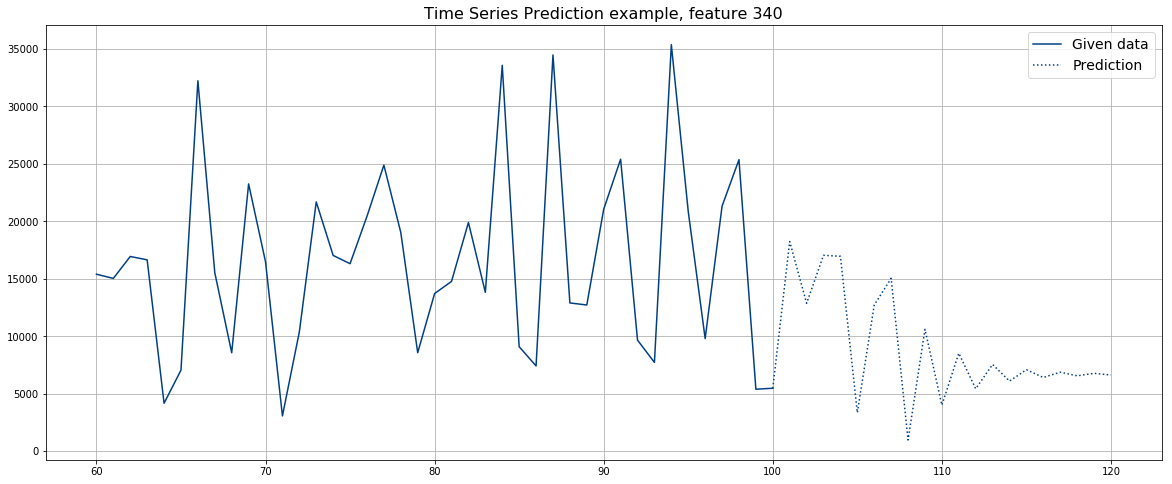

In [74]:
data = list(df2018[335])
data = [float(x) for x in data]

# Plot the data
plt.plot(range(60, 121)[0:41],data[0:41], label='Given data', color='#013F85')
plt.plot(range(60, 121)[40:],data[40:], label='Prediction', color='#013F85', linestyle=':')
plt.title('Time Series Prediction example, feature 340', size=16)
plt.rcParams['figure.figsize'] = [20, 8]
plt.grid()
plt.legend(prop={'size': 14})
plt.show();

### Prepare the data and predictions for YoY graph

The figure below shows the revenue for 2017 and 2018, where the dotted lines included predicted values. 

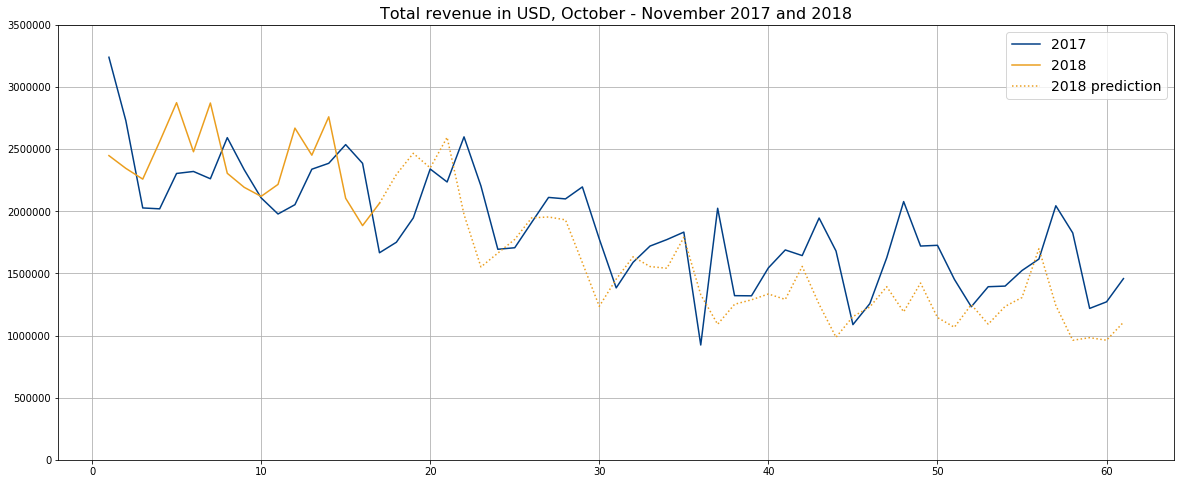

In [73]:

totals_2017 = [0] * 61
totals_2018 = [0] * 61

for i in range(1,363):
    data2017 = list(df2017[i])   
    data2017 = [0 if x=='' else x for x in data2017]
    data2017 = [float(x) for x in data2017]
    totals_2017 = list( map(add, totals_2017, data2017) )
    
    data2018 = list(df2018[i])   
    data2018 = [0 if x=='' else x for x in data2018]
    data2018 = [float(x) for x in data2018]
    totals_2018 = list( map(add, totals_2018, data2018) )

# Plot YoY graph with the total revenue prediction
plt.plot(range(1, 62),totals_2017, label='2017', color='#013F85')
plt.plot(range(1, 62)[0:17],totals_2018[0:17], label='2018', color='#EB9E1E')
plt.plot(range(1, 62)[16:],totals_2018[16:], label='2018 prediction', color='#EB9E1E', linestyle=':')
plt.grid()
plt.legend(prop={'size': 14})
plt.title('Total revenue in USD, October - November 2017 and 2018', size=16)

axes = plt.gca()
axes.set_ylim([0,3500000])#np.max(totals_2017)+1000])
plt.rcParams['figure.figsize'] = [20, 8]

plt.show()
